Original code is from https://github.com/baegwangbin/surface_normal_uncertainty and edited slightly.
Generated normal maps are compared against those generated in https://github.com/Xharlie/ShapenetRender_more_variation/tree/master, where test images are taken from Shapenet. The original images are stored under folder /image_1176dff7f0ec879719d740e0f6a9a113 and the normal maps used as the benchmark are stored under folder /normal_1176dff7f0ec879719d740e0f6a9a113.

In [6]:
# set up virtual environment and install dependencies
# !python -m venv --system-site-packages ./venv
# !venv\Scripts\Activate.ps1
!python -m pip install -r requirements.txt
!pip install matplotlib-inline

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached traitlets-5.14.3-py3-none-any.whl.metadata (10 kB)
Using cached traitlets-5.14.3-py3-none-any.whl (85 kB)



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# generate normal maps of original size 224 x 224 into results_BN folder
!python test.py --pretrained scannet --architecture BN --results_dir results_BN --input_height 224 --input_width 224
# generate normal maps of large size 448 x 448 into results_large_BN folder
!python test.py --pretrained scannet --architecture BN --results_dir results_large_BN --input_height 448 --input_width 448

CUDA available: True
Build: 2.5.1+cu121
loading checkpoint... ./checkpoints/scannet.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

CUDA available: True
Build: 2.5.1+cu121
loading checkpoint... ./checkpoints/scannet.pt
Loading base model ()...Done.
Removing last two layers (global_pool & classifier).
loading checkpoint... / done


Using cache found in C:\Users\alexl/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
c:\Users\alexl\OneDrive\Documents\GitHub\surface_normal_uncertainty\utils\utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [12]:
# resizing large normal maps to original size
from PIL import Image
import os

orig = "results_large_BN"
os.mkdir("results_resized_BN")

if os.path.isdir(orig):
    for filename in os.listdir(orig):
        if filename.lower().endswith(".png"):
            img = Image.open(os.path.join(orig, filename))
            img_resized = img.resize((224, 224))
            img_resized.save(os.path.join("results_resized_BN", filename))
else:
    print(f"Folder {orig} not found.")

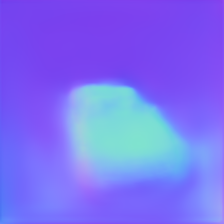

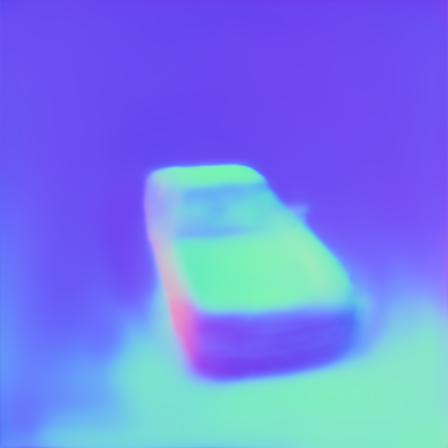

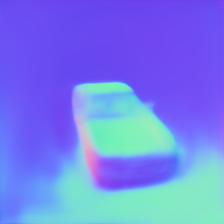

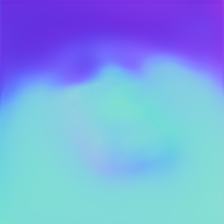

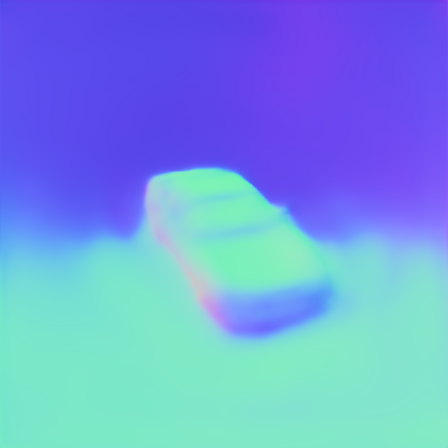

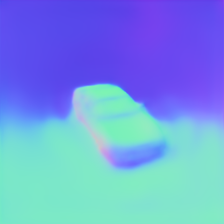

In [13]:
from IPython.display import Image, display
# for some images, there is not much of a difference
display(Image(filename='results_BN/easy-00.png'))
display(Image(filename='results_large_BN/easy-00.png'))
display(Image(filename='results_resized_BN/easy-00.png'))
# for other images, the larger input size captures more details
display(Image(filename='results_BN/easy-01.png'))
display(Image(filename='results_large_BN/easy-01.png'))
display(Image(filename='results_resized_BN/easy-01.png'))

In [15]:
# compare PSNR of original vs large then resized images
import os
import torchvision
import torchmetrics
import numpy as np

preds = ["results_BN", "results_resized_BN"]
true = "normal_1176dff7f0ec879719d740e0f6a9a113"
psnr_fn = torchmetrics.image.PeakSignalNoiseRatio(data_range=1.0)
psnrs = {}

for pred in preds:
    psnrs[pred] = []
    if os.path.isdir(pred):
        for filename in os.listdir(pred):
            if filename.lower().endswith(".png"):
                if filename in os.listdir(true):
                    imghat = torchvision.io.read_image(os.path.join(pred, filename)) / 255
                    #imghat = imghat.permute(1,2,0).reshape(-1, 3)
                    img = torchvision.io.read_image(os.path.join(true, filename)) / 255
                    #img = img.permute(1,2,0).reshape(-1, 3)
                    psnr = psnr_fn(imghat, img)
                    psnrs[pred].append(psnr.item())
                    # print(f"PSNR for {filename}: {psnr.item():.2f} dB")
                else:
                    print(f"File {filename} in predicted folder has no match in true folder.")
    else:
        print(f"Predicted folder {pred} not found.")

for pred in psnrs:
    avg_psnr = np.mean(psnrs[pred])
    print(f"Average PSNR for {pred}: {avg_psnr:.2f}")
    std_psnr = np.std(psnrs[pred])
    print(f"Standard Deviation of PSNR for {pred}: {std_psnr:.2f}")

Average PSNR for results_BN: 12.93
Standard Deviation of PSNR for results_BN: 0.93
Average PSNR for results_resized_BN: 13.06
Standard Deviation of PSNR for results_resized_BN: 0.63
